In [2]:
from sklearn.feature_selection import f_classif

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.spatial.distance import jensenshannon
import seaborn as sns

from preprocess import Preprocessor
from dataset import DatasetLoader, FakeOrRealLabel
from textual_relevance import TextualRelevance
from non_latent_features import NonLatentFeatures

pp = Preprocessor(lowercase=False,remove_non_ascii=True, remove_punctuation=False, lemmatization=False, remove_stopwords=False)
ds = DatasetLoader()
df = ds.load_horne2017_fakenewsdata(drop_if_less_than_num_contexts=1).as_pandas()

df = df[['id', 'label', 'title', 'content', 'ctx1_title', 'ctx1_content', 'ctx2_title', 'ctx2_content', 'ctx3_title', 'ctx3_content']]

df['label'] = df['label'].apply(lambda label: 1 if label == FakeOrRealLabel.REAL else 0)

for col in ["content", "ctx1_content", "ctx2_content", "ctx3_content"]:
    df[col] = df[col].apply(pp.preprocess)

In [3]:
def extract_non_latent(row):
    def extract_non_latent_func(x):
        if x is None:
            return 0
        if not isinstance(x, str) and pd.isnull(x):
            return 0
        return len(pp.preprocess_and_tokenize(x))
    total_dict = {}
    for k in ['div_NOUN_sum', 'div_NOUN_percent', 'div_VERB_sum', 'div_VERB_percent', 'div_ADJ_sum', 'div_ADJ_percent', 'div_ADV_sum', 'div_ADV_percent', 'div_LEX_sum', 'div_LEX_percent', 'div_CONT_sum', 'div_CONT_percent', 'div_FUNC_sum', 'div_FUNC_percent', 'pron_FPS_sum', 'pron_FPS_percent', 'pron_FPP_sum', 'pron_FPP_percent', 'pron_STP_sum', 'pron_STP_percent', 'quant_NOUN_sum', 'quant_NOUN_percent', 'quant_VERB_sum', 'quant_VERB_percent', 'quant_ADJ_sum', 'quant_ADJ_percent', 'quant_ADV_sum', 'quant_ADV_percent', 'quant_PRON_sum', 'quant_PRON_percent', 'quant_DET_sum', 'quant_DET_percent', 'quant_NUM_sum', 'quant_NUM_percent', 'quant_PUNCT_sum', 'quant_PUNCT_percent', 'quant_SYM_sum', 'quant_SYM_percent', 'quant_PRP_sum', 'quant_PRP_percent', 'quant_PRP$_sum', 'quant_PRP$_percent', 'quant_WDT_sum', 'quant_WDT_percent', 'quant_CD_sum', 'quant_CD_percent', 'quant_VBD_sum', 'quant_VBD_percent', 'quant_STOP_sum', 'quant_STOP_percent', 'quant_LOW_sum', 'quant_LOW_percent', 'quant_UP_sum', 'quant_UP_percent', 'quant_NEG_sum', 'quant_NEG_percent', 'quant_QUOTE_sum', 'quant_NP_sum', 'quant_CHAR_sum', 'quant_WORD_sum', 'quant_SENT_sum', 'quant_SYLL_sum', 'senti_!_sum', 'senti_!_percent', 'senti_?_sum', 'senti_?_percent', 'senti_CAPS_sum', 'senti_CAPS_percent', 'senti_POL_sum', 'senti_SUBJ_sum', 'avg_chars_per_word_sum', 'avg_words_per_sent_sum', 'avg_claus_per_sent_sum', 'avg_puncts_per_sent_sum', 'med_st_ALL_sum', 'med_st_NP_sum', 'read_gunning-fog_sum', 'read_coleman-liau_sum', 'read_dale-chall_sum', 'read_flesch-kincaid_sum', 'read_linsear-write_sum', 'read_spache_sum', 'read_automatic_sum', 'read_flesch_sum']:
        for content_k in ("content", "ctx1_content", "ctx2_content", "ctx3_content"):
            total_dict[content_k + '_' + k] = 0
        
    for key in ("content", "ctx1_content", "ctx2_content", "ctx3_content"):
        if row[key] is None:
            continue
        if not isinstance(row[key], str) and pd.isnull(row[key]):
            continue

        non_latent_dict = NonLatentFeatures(row[key]).output_all()        
        for k, v in non_latent_dict.items():
            total_dict[key + '_' + k] = v
    return pd.Series(total_dict.values(), total_dict.keys())
df = pd.concat([df, df.apply(extract_non_latent, axis=1)], axis=1)

df.to_csv('fakeNewsDataset.csv')
df = pd.read_csv('fakeNewsDataset.csv')

In [4]:
def display_plot(p_values_sorted):
    fig, ax = plt.subplots()

    # hide axes
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')

    table = ax.table(cellText=[(x[0][8:], np.format_float_scientific(x[1], precision=2, exp_digits=2)) for x in p_values_sorted], colLabels=['category', 'p-value'], loc='center')

    for x in np.where(np.array([x[1] for x in p_values_sorted]) >= 0.05)[0]:
        table[(x + 1, 0)].set_facecolor("#56b5fd")
        table[(x + 1, 1)].set_facecolor("#56b5fd")

    fig.tight_layout()

    plt.show()

/tmp/ipykernel_29465/3227983106.py:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


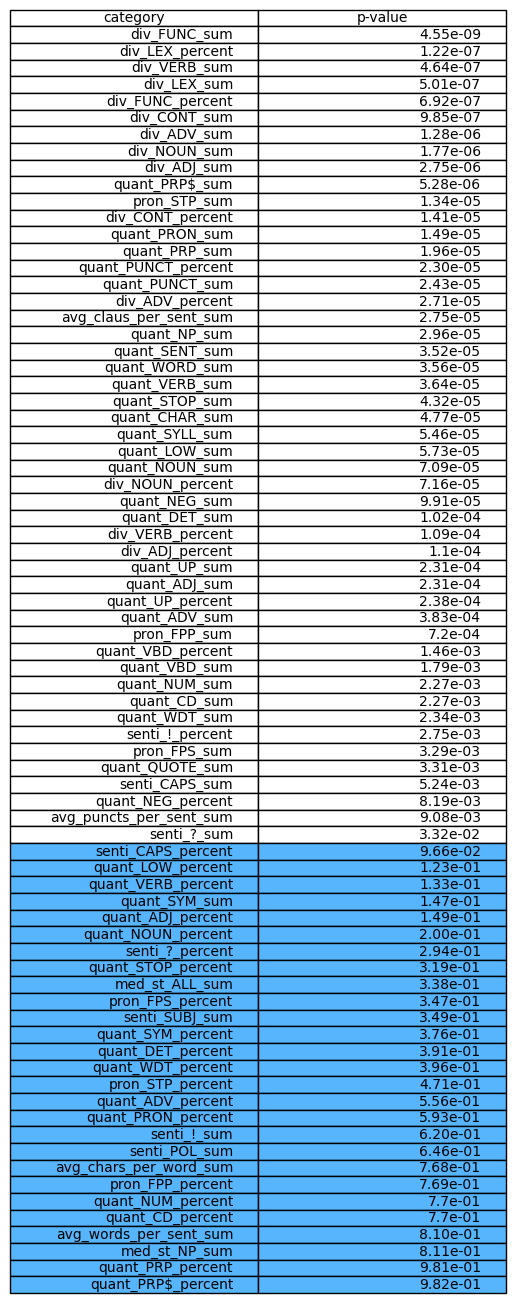

In [5]:
# Get all the features to feed into the two models
feats = []
for k in ['div_NOUN_sum', 'div_NOUN_percent', 'div_VERB_sum', 'div_VERB_percent', 'div_ADJ_sum', 'div_ADJ_percent', 'div_ADV_sum', 'div_ADV_percent', 'div_LEX_sum', 'div_LEX_percent', 'div_CONT_sum', 'div_CONT_percent', 'div_FUNC_sum', 'div_FUNC_percent', 'pron_FPS_sum', 'pron_FPS_percent', 'pron_FPP_sum', 'pron_FPP_percent', 'pron_STP_sum', 'pron_STP_percent', 'quant_NOUN_sum', 'quant_NOUN_percent', 'quant_VERB_sum', 'quant_VERB_percent', 'quant_ADJ_sum', 'quant_ADJ_percent', 'quant_ADV_sum', 'quant_ADV_percent', 'quant_PRON_sum', 'quant_PRON_percent', 'quant_DET_sum', 'quant_DET_percent', 'quant_NUM_sum', 'quant_NUM_percent', 'quant_PUNCT_sum', 'quant_PUNCT_percent', 'quant_SYM_sum', 'quant_SYM_percent', 'quant_PRP_sum', 'quant_PRP_percent', 'quant_PRP$_sum', 'quant_PRP$_percent', 'quant_WDT_sum', 'quant_WDT_percent', 'quant_CD_sum', 'quant_CD_percent', 'quant_VBD_sum', 'quant_VBD_percent', 'quant_STOP_sum', 'quant_STOP_percent', 'quant_LOW_sum', 'quant_LOW_percent', 'quant_UP_sum', 'quant_UP_percent', 'quant_NEG_sum', 'quant_NEG_percent', 'quant_QUOTE_sum', 'quant_NP_sum', 'quant_CHAR_sum', 'quant_WORD_sum', 'quant_SENT_sum', 'quant_SYLL_sum', 'senti_!_sum', 'senti_!_percent', 'senti_?_sum', 'senti_?_percent', 'senti_CAPS_sum', 'senti_CAPS_percent', 'senti_POL_sum', 'senti_SUBJ_sum', 'avg_chars_per_word_sum', 'avg_words_per_sent_sum', 'avg_claus_per_sent_sum', 'avg_puncts_per_sent_sum', 'med_st_ALL_sum', 'med_st_NP_sum']:
    feats.append('content_' + k)

# ANOVA
f_stats, p_values = f_classif(df[feats], df.label)
p_values_sorted = sorted(list(zip(feats, p_values)), key=lambda x: x[1])

display_plot(p_values_sorted)

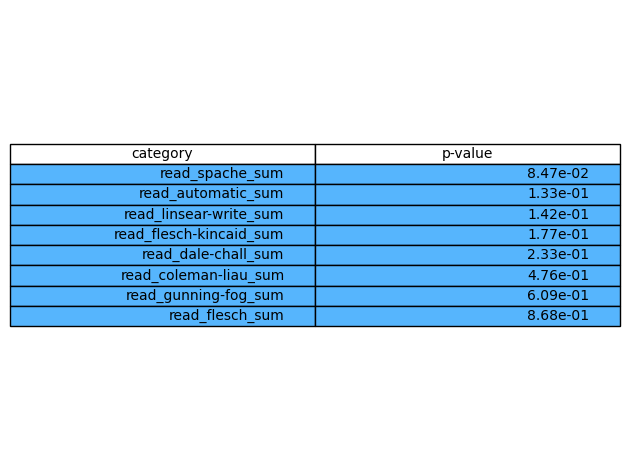

In [7]:
read_feats = []
for k in ['read_gunning-fog_sum', 'read_coleman-liau_sum', 'read_dale-chall_sum', 'read_flesch-kincaid_sum', 'read_linsear-write_sum', 'read_spache_sum', 'read_automatic_sum', 'read_flesch_sum']:
    read_feats.append('content_' + k)

read_df = df[read_feats + ['label']]
read_df.dropna()

# # ANOVA
read_f_stats, read_p_values = f_classif(read_df[read_feats], read_df.label)
read_p_values_sorted = sorted(list(zip(read_feats, read_p_values)), key=lambda x: x[1])

display_plot(read_p_values_sorted)

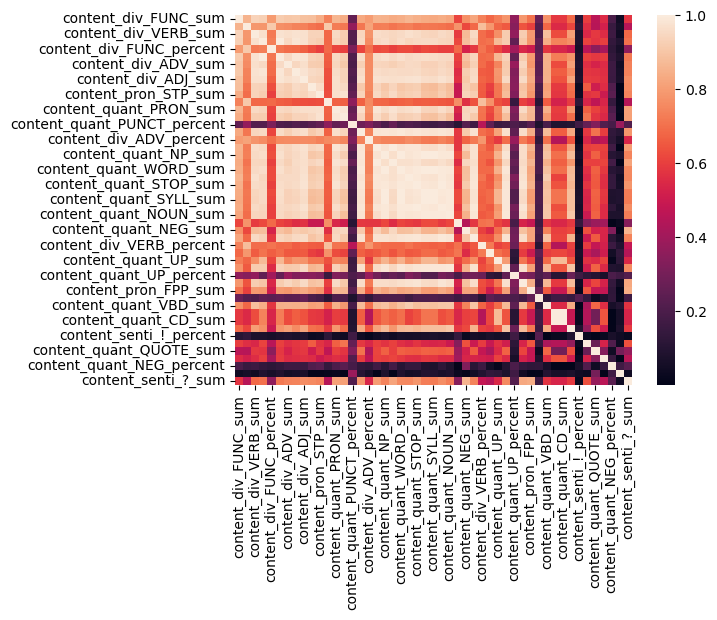

In [8]:
# https://lifewithdata.com/2022/03/13/how-to-remove-highly-correlated-features-from-a-dataset/
# https://www.projectpro.io/recipes/drop-out-highly-correlated-features-in-python
# create correlation  matrix
vals = [y[0] for y in filter(lambda x: x[1] < 0.05, p_values_sorted)]

corr_matrx = df[vals].corr().abs()

sns.heatmap(corr_matrx)
plt.show()

In [9]:
upper_tri = corr_matrx.where(np.triu(np.ones(corr_matrx.shape),k=1).astype(np.bool))

dict_ = dict(enumerate([i[0] for i in p_values_sorted]))
new_dict = {}
for k, v in dict_.items():
    new_dict[v] = int(k)

to_iterate_l = sorted(list(upper_tri.index), key=lambda x: new_dict[x])
graph_dict = {}

to_skip = set()
for row in to_iterate_l:
    if row in to_skip:
        continue
    for col in to_iterate_l:
        cell = upper_tri.loc[row][col]
        if cell > 0.95:
            graph_dict[row] = graph_dict.get(row, [])
            graph_dict[row].append(col)
            to_skip.add(col)
    
    # Solitary ones
    if graph_dict.get(row, []) == []:
        graph_dict[row] = []

final_dict = {}
for col in graph_dict.keys():
    k = col.split('_')[1]
    final_dict[k] = final_dict.get(k, [])
    final_dict[k].append(col)
    
final_dict

/tmp/ipykernel_29465/1102003037.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = corr_matrx.where(np.triu(np.ones(corr_matrx.shape),k=1).astype(np.bool))


{'div': ['content_div_FUNC_sum',
  'content_div_LEX_percent',
  'content_div_VERB_sum',
  'content_div_FUNC_percent',
  'content_div_CONT_percent',
  'content_div_ADV_percent',
  'content_div_NOUN_percent',
  'content_div_VERB_percent',
  'content_div_ADJ_percent'],
 'quant': ['content_quant_PRP$_sum',
  'content_quant_PUNCT_percent',
  'content_quant_PUNCT_sum',
  'content_quant_NEG_sum',
  'content_quant_UP_sum',
  'content_quant_UP_percent',
  'content_quant_VBD_percent',
  'content_quant_VBD_sum',
  'content_quant_NUM_sum',
  'content_quant_WDT_sum',
  'content_quant_QUOTE_sum',
  'content_quant_NEG_percent'],
 'pron': ['content_pron_FPP_sum', 'content_pron_FPS_sum'],
 'senti': ['content_senti_!_percent',
  'content_senti_CAPS_sum',
  'content_senti_?_sum'],
 'avg': ['content_avg_puncts_per_sent_sum']}

In [11]:
from scipy import spatial

col_p = dict(p_values_sorted)

def non_latent_cosine_dist(row):
    predict_vec = np.array([row[col] for col in col_p])
    context_vecs = []
    # get all vec of context vectors here
    for type_ in ["ctx1_content", "ctx2_content", "ctx3_content"]:
        if isinstance(row[type_], str) and len(row[type_]) > 0:
            context_vec = np.array([row[type_ + col[7:]] for col in col_p])
            context_vecs.append(context_vec)

    val = np.mean([1 - spatial.distance.cosine(predict_vec, context_vec) for context_vec in context_vecs])

    return pd.Series([val], ['non_latent_cosine_dist'])

# ANOVA
non_latent_cosine_dist_df = df.apply(non_latent_cosine_dist, axis=1)
f_stats, p_values = f_classif(non_latent_cosine_dist_df.to_numpy(), df.label)

# # REALLY BAD RESULTS
print(p_values[0])

0.7920764074665805


Apply the above pipeline to Title instead of text
(2: apply non latent feature extraction and selection on titles and perform ANOVA with labels and use selected feats as additional feats to model )

1: title and body vector of real articles have higher similarity than those of fake art

Find a common way to extract vector from both body and title, maybe tf-idf, maybe word2vec. maybe using the metrics above

In [18]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)

df

,Unnamed: 0,id,label,title,content,...,ctx3_content_read_automatic_sum,content_read_flesch_sum,ctx1_content_read_flesch_sum,ctx2_content_read_flesch_sum,ctx3_content_read_flesch_sum
0,0,105_Real,1,Aziz Ansari Why Trump Makes Me Scared for My F...,"DONT go anywhere near a mosque, I told my moth...",...,14.925972,62.752475,51.660333,45.234241,40.573359
1,1,124_Real,1,I Ran the C.I.A. Now I'm Endorsing Hillary Cli...,During a 33-year career at the Central Intelli...,...,14.957641,46.397398,49.961767,35.293750,40.369145
2,2,151_Real,1,Why Donald Trump Should Not Be President\n,When Donald Trump began his improbable run for...,...,0.000000,36.956821,27.181521,37.024421,0.000000
3,3,140_Real,1,The rise of Donald Trump is a terrifying momen...,"On Monday, Donald Trump held a rally in Manche...",...,7.801952,60.433140,61.622923,54.187779,66.045541
4,4,138_Real,1,The real Clinton email scandal is that a bulls...,"Some time ago, Hillary Clinton and her adviser...",...,14.774937,44.197597,35.464571,35.034956,38.948345
...,...,...,...,...,...,...,...,...,...,...,...
92,92,23_Fake,0,ISIS LEADER CALLS FOR AMERICAN MUSLIM VOTERS T...,Top ISIS leader now believed to be the number ...,...,0.000000,38.235338,34.378087,0.000000,0.000000
93,93,40_Fake,0,Sauron Endorses Donald Trump for President\n,Trump refuses to disavow the Dark Lords suppor...,...,11.467807,45.586140,38.349043,55.530606,56.857505
94,94,14_Fake,0,"""Donald Trump Protester Speaks Out """"I Was Pai...","PHOENIX A.Z. (AP) For months now, rumors have...",...,5.057150,61.482473,64.920116,0.000000,75.052034
95,95,26_Fake,0,Longtime mistress says Bill Clinton had 2000 s...,Another long-time lover of Bill Clinton has co...,...,12.094343,51.135804,65.305923,59.208646,47.173504


## TEXTUAL RELEVANCE (OLD)

In [4]:
# df = pd.read_csv('fakeNewsDataset.csv')

In [5]:
pp = Preprocessor()

for col in ["content", "ctx1_content", "ctx2_content", "ctx3_content"]:
    df[col + '_token'] = df[col].apply(pp.tokenize_opt)

tfidf_1_1 = TextualRelevance('tfidf', df.content, ngram_range=(1, 1))
tfidf_1_2 = TextualRelevance('tfidf', df.content, ngram_range=(1, 2))
word2vec = TextualRelevance('word2vec')

tf_idf_1_1_cosine_dist = []
tf_idf_1_1_word_app = []
tf_idf_1_1_matching = []

tf_idf_1_2_cosine_dist = []
tf_idf_1_2_word_app = []
tf_idf_1_2_matching = []

word2vec_cosine_dist = []

for i in range(len(df)):
    contents = []
    for context in [df['ctx1_content_token'].iloc[i], df['ctx2_content_token'].iloc[i], df['ctx3_content_token'].iloc[i]]:
        if isinstance(context, list):
            contents.append(context)

    tf_idf_1_1_cosine_dist.append(tfidf_1_1.cosine_dist(df['content_token'].iloc[i], contents))
    tf_idf_1_1_word_app.append(tfidf_1_1.word_appearance(df['content_token'].iloc[i], contents))
    tf_idf_1_1_matching.append(tfidf_1_1.matching_score(df['content_token'].iloc[i], contents))

    tf_idf_1_2_cosine_dist.append(tfidf_1_2.cosine_dist(df['content_token'].iloc[i], contents))
    tf_idf_1_2_word_app.append(tfidf_1_2.word_appearance(df['content_token'].iloc[i], contents))
    tf_idf_1_2_matching.append(tfidf_1_2.matching_score(df['content_token'].iloc[i], contents))

    
    word2vec_cosine_dist.append(word2vec.cosine_dist(df['content_token'].iloc[i], contents))

/home/duke/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/duke/anaconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:620: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [6]:
df['tf_idf_1_1_cosine_dist'] = tf_idf_1_1_cosine_dist
df['tf_idf_1_1_word_app'] = tf_idf_1_1_word_app
df['tf_idf_1_1_matching'] = tf_idf_1_1_matching

df['tf_idf_1_2_cosine_dist'] = tf_idf_1_2_cosine_dist
df['tf_idf_1_2_word_app'] = tf_idf_1_2_word_app
df['tf_idf_1_2_matching'] = tf_idf_1_2_matching

df['word2vec_cosine_dist'] = word2vec_cosine_dist

tf_idf_1_1_cosine_dist = np.array(tf_idf_1_1_cosine_dist)
tf_idf_1_1_word_app = np.array(tf_idf_1_1_word_app)
tf_idf_1_1_matching = np.array(tf_idf_1_1_matching)

tf_idf_1_2_cosine_dist = np.array(tf_idf_1_2_cosine_dist)
tf_idf_1_2_word_app = np.array(tf_idf_1_2_word_app)
tf_idf_1_2_matching = np.array(tf_idf_1_2_matching)

df['tf_idf_1_1_harmonic_mean'] = 3 / ((1/tf_idf_1_1_cosine_dist) + (1/tf_idf_1_1_word_app) + (1/tf_idf_1_1_matching))
df['tf_idf_1_2_harmonic_mean'] = 3 / ((1/tf_idf_1_2_cosine_dist) + (1/tf_idf_1_2_word_app) + (1/tf_idf_1_2_matching))

In [7]:
methods = ['word2vec_cosine_dist', 'tf_idf_1_1_cosine_dist', 'tf_idf_1_1_word_app', 'tf_idf_1_1_matching', 'tf_idf_1_2_cosine_dist', 'tf_idf_1_2_word_app', 'tf_idf_1_2_matching', 'tf_idf_1_1_harmonic_mean', 'tf_idf_1_2_harmonic_mean']
# updated_df = df[['id', 'title', 'label'] + methods]

Comparison between
- Cosine Distance: Word2Vec, TF-IDF(1-1), TF-IDF(1-2)
- Word App: TF-IDF(1-1), TF-IDF(1-2)
- Matching Score: TF-IDF(1-1), TF-IDF(1-2)
- Harmonic Mean of Three Metrics: TF-IDF(1-1), TF-IDF(1-2)

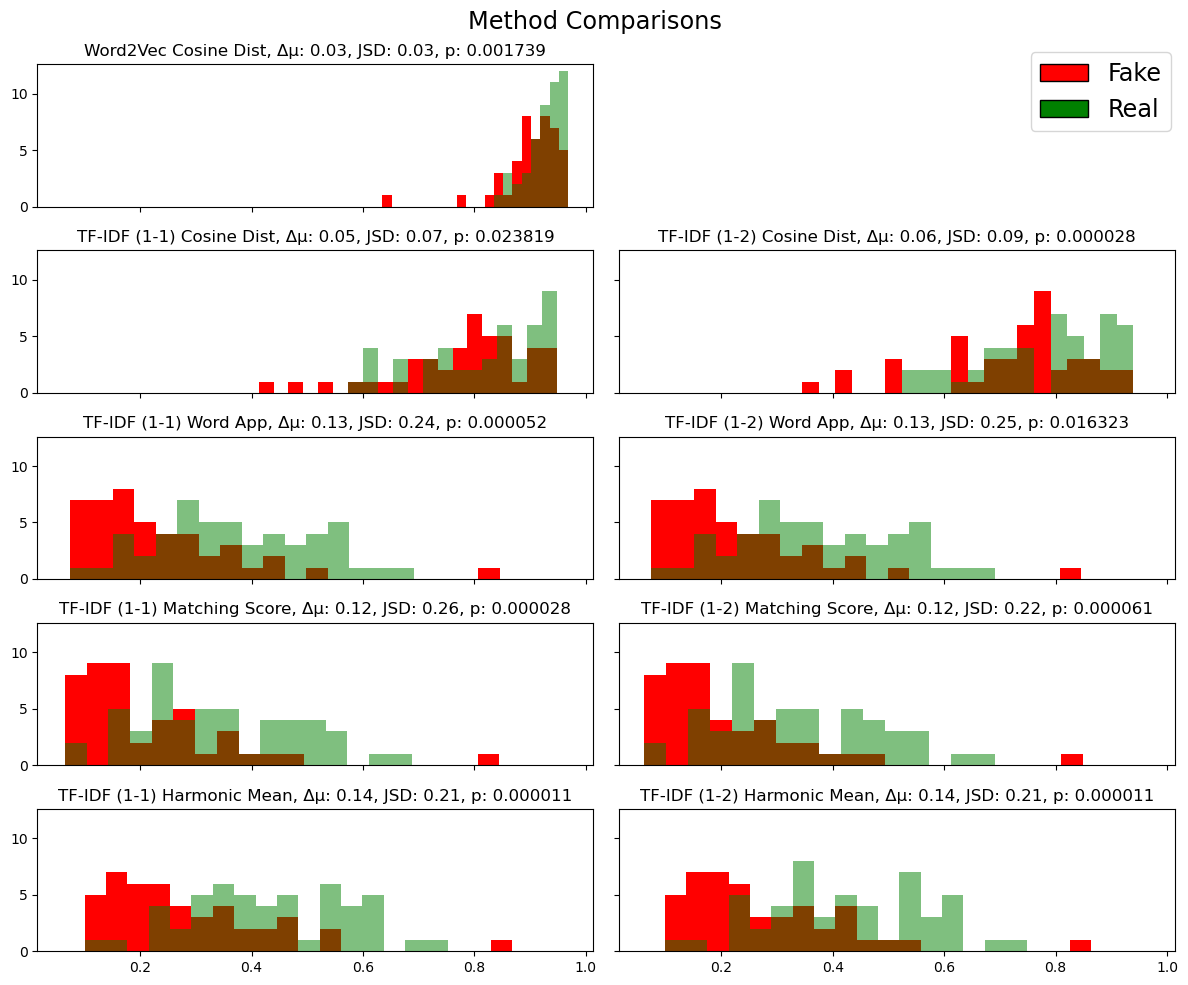

In [8]:
def jsd(p, q, base=np.e):
    '''Jenson-Shanon Distance
    Reference: https://stackoverflow.com/questions/20302636/js-divergence-between-two-discrete-probability-distributions-of-unequal-length
    '''
    if len(p) > len(q):
        p = np.random.choice(p, len(q)) # random.choice make same length to p/q
    elif len(q) > len(p):
        q = np.random.choice(q, len(p))
    p, q = np.asarray(p), np.asarray(q)
    
    return jensenshannon(p, q)

colors = ["red", "green"]
labels = ["Fake", "Real"]

f_classif_input = np.array([df[method] for method in methods]).T

# ANOVA
f_stats, p_values = f_classif(f_classif_input, df.label)

def plot_given_method(ax_, df, p_val, method, method_name):
    _, bins, _ = ax_.hist(df[df.label == 0][method], bins=20, color = colors[0])
    _ = ax_.hist(df[df.label == 1][method], bins=bins, alpha = 0.5, color = colors[1])
    
    # Use Jensen-Shannon Distance
    dist = jsd(df[df.label == 0][method], df[df.label == 1][method])
    delta_mu = abs(df[df.label == 0][method].mean() - df[df.label == 1][method].mean())

    ax_.set_title(f"{method_name}, Δµ: {delta_mu:.2f}, JSD: {dist:.2f}, p: {p_val:.6f}")

fig, axes = plt.subplots(ncols=2, nrows=5, figsize=(12, 10), sharex=True, sharey=True)
ax = axes.ravel()
ax[1].set_visible(False)

plot_given_method(ax[0], df, p_values[0], 'word2vec_cosine_dist', 'Word2Vec Cosine Dist')
plot_given_method(ax[2], df, p_values[1], 'tf_idf_1_1_cosine_dist', 'TF-IDF (1-1) Cosine Dist')
plot_given_method(ax[3], df, p_values[2], 'tf_idf_1_2_cosine_dist', 'TF-IDF (1-2) Cosine Dist')
plot_given_method(ax[4], df, p_values[3], 'tf_idf_1_1_word_app', 'TF-IDF (1-1) Word App')
plot_given_method(ax[5], df, p_values[4], 'tf_idf_1_2_word_app', 'TF-IDF (1-2) Word App')
plot_given_method(ax[6], df, p_values[5], 'tf_idf_1_1_matching', 'TF-IDF (1-1) Matching Score')
plot_given_method(ax[7], df, p_values[6], 'tf_idf_1_2_matching', 'TF-IDF (1-2) Matching Score')
plot_given_method(ax[8], df, p_values[7], 'tf_idf_1_1_harmonic_mean', 'TF-IDF (1-1) Harmonic Mean')
plot_given_method(ax[9], df, p_values[8], 'tf_idf_1_2_harmonic_mean', 'TF-IDF (1-2) Harmonic Mean')

handles = [Rectangle((0, 0), 1, 1, color=c, ec="k") for c in colors]
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.49, 0.45, 0.5, 0.5), fontsize='xx-large')

fig.suptitle('Method Comparisons', fontsize='xx-large')
fig.tight_layout()

In [12]:
# pd.set_option('display.max_rows', 100)
# pd.set_option('display.max_columns', 100)

# df

,Unnamed: 0,id,label,title,content,ctx1_title,ctx1_content,ctx2_title,ctx2_content,ctx3_title,ctx3_content,content_div_NOUN_sum,ctx1_content_div_NOUN_sum,ctx2_content_div_NOUN_sum,ctx3_content_div_NOUN_sum,content_div_NOUN_percent,ctx1_content_div_NOUN_percent,ctx2_content_div_NOUN_percent,ctx3_content_div_NOUN_percent,content_div_VERB_sum,ctx1_content_div_VERB_sum,ctx2_content_div_VERB_sum,ctx3_content_div_VERB_sum,content_div_VERB_percent,ctx1_content_div_VERB_percent,ctx2_content_div_VERB_percent,ctx3_content_div_VERB_percent,content_div_ADJ_sum,ctx1_content_div_ADJ_sum,ctx2_content_div_ADJ_sum,ctx3_content_div_ADJ_sum,content_div_ADJ_percent,ctx1_content_div_ADJ_percent,ctx2_content_div_ADJ_percent,ctx3_content_div_ADJ_percent,content_div_ADV_sum,ctx1_content_div_ADV_sum,ctx2_content_div_ADV_sum,ctx3_content_div_ADV_sum,content_div_ADV_percent,ctx1_content_div_ADV_percent,ctx2_content_div_ADV_percent,ctx3_content_div_ADV_percent,content_div_LEX_sum,ctx1_content_div_LEX_sum,ctx2_content_div_LEX_sum,ctx3_content_div_LEX_sum,content_div_LEX_percent,ctx1_content_div_LEX_percent,ctx2_content_div_LEX_percent,...,ctx3_content_med_st_ALL_sum,content_med_st_NP_sum,ctx1_content_med_st_NP_sum,ctx2_content_med_st_NP_sum,ctx3_content_med_st_NP_sum,content_read_gunning-fog_sum,ctx1_content_read_gunning-fog_sum,ctx2_content_read_gunning-fog_sum,ctx3_content_read_gunning-fog_sum,content_read_coleman-liau_sum,ctx1_content_read_coleman-liau_sum,ctx2_content_read_coleman-liau_sum,ctx3_content_read_coleman-liau_sum,content_read_dale-chall_sum,ctx1_content_read_dale-chall_sum,ctx2_content_read_dale-chall_sum,ctx3_content_read_dale-chall_sum,content_read_flesch-kincaid_sum,ctx1_content_read_flesch-kincaid_sum,ctx2_content_read_flesch-kincaid_sum,ctx3_content_read_flesch-kincaid_sum,content_read_linsear-write_sum,ctx1_content_read_linsear-write_sum,ctx2_content_read_linsear-write_sum,ctx3_content_read_linsear-write_sum,content_read_spache_sum,ctx1_content_read_spache_sum,ctx2_content_read_spache_sum,ctx3_content_read_spache_sum,content_read_automatic_sum,ctx1_content_read_automatic_sum,ctx2_content_read_automatic_sum,ctx3_content_read_automatic_sum,content_read_flesch_sum,ctx1_content_read_flesch_sum,ctx2_content_read_flesch_sum,ctx3_content_read_flesch_sum,content_token,ctx1_content_token,ctx2_content_token,ctx3_content_token,tf_idf_1_1_cosine_dist,tf_idf_1_1_word_app,tf_idf_1_1_matching,tf_idf_1_2_cosine_dist,tf_idf_1_2_word_app,tf_idf_1_2_matching,word2vec_cosine_dist,tf_idf_1_1_harmonic_mean,tf_idf_1_2_harmonic_mean
0,0,105_Real,1,Aziz Ansari Why Trump Makes Me Scared for My F...,"DONT go anywhere near a mosque, I told my moth...","Orlando shooting: 49 killed, shooter pledged I...","Orlando, Florida CNN \n\nAn American-born man ...",Donald Trump Seizes on Orlando Shooting and Re...,Mrs. Clinton did not use that phrase or respon...,Trump revives talk of banning Muslims after Or...,"MANCHESTER, N.H. In his first formal remarks ...",135.0,249.0,48.0,95.0,0.710526,0.555804,0.842105,0.669014,86.0,145.0,24.0,68.0,0.677165,0.517857,0.685714,0.723404,56.0,75.0,19.0,40.0,0.682927,0.781250,1.000000,0.816327,29.0,37.0,8.0,17.0,0.783784,0.660714,1.000000,0.894737,459.0,838.0,158.0,353.0,0.402985,0.341066,0.585185,...,5.0,1.0,1.0,1.0,1.0,10.889955,11.076207,14.580921,15.180005,8.661119,10.669408,11.894059,11.939469,8.196001,9.349564,10.239430,10.559296,8.845153,10.456582,12.648485,13.914082,11.419643,12.173729,16.050000,18.018519,5.809996,6.915873,7.555344,8.373728,8.565084,10.289572,13.695565,14.925972,62.752475,51.660333,45.234241,40.573359,"[DONT, go, anywhere, near, a, mosque, ,, I, to...","[Orlando, ,, Florida, CNN, An, American, -, bo...","[Mrs, ., Clinton, did, not, use, that, phrase,...","[MANCHESTER, ,, N, ., H, ., In, his, first, fo...",0.919901,0.309197,0.272767,0.820441,0.309197,0.264400,0.905150,0.375592,0.364291
1,1,124_Real,1,I Ran the C.I.A. Now I'm Endorsing Hillary Cli...,During a 33-year career at the Central Intelli...,Trump backs Put

## Export CSV

In [9]:
df.to_csv('fakeNewsDataset.csv')

In [ ]:
# def check_len(x):
#     if x is None:
#         return 0
#     if not isinstance(x, str) and pd.isnull(x):
#         return 0
#     return len(pp.preprocess_and_tokenize(x))

# for col in ["content", "ctx1_content", "ctx2_content", "ctx3_content"]:
#     df[col + '_len'] = df[col].apply(check_len)    


In [ ]:
# # A union-find disjoint set data structure.
# # https://github.com/deehzee/unionfind/blob/master/UnionFindExamples.ipynb

# # 2to3 sanity
# from __future__ import (
#     absolute_import, division, print_function, unicode_literals,
# )

# # Third-party libraries
# import numpy as np


# class UnionFind(object):
#     """Union-find disjoint sets datastructure.

#     Union-find is a data structure that maintains disjoint set
#     (called connected components or components in short) membership,
#     and makes it easier to merge (union) two components, and to find
#     if two elements are connected (i.e., belong to the same
#     component).

#     This implements the "weighted-quick-union-with-path-compression"
#     union-find algorithm.  Only works if elements are immutable
#     objects.

#     Worst case for union and find: :math:`(N + M \log^* N)`, with
#     :math:`N` elements and :math:`M` unions. The function
#     :math:`\log^*` is the number of times needed to take :math:`\log`
#     of a number until reaching 1. In practice, the amortized cost of
#     each operation is nearly linear [1]_.

#     Terms
#     -----
#     Component
#         Elements belonging to the same disjoint set

#     Connected
#         Two elements are connected if they belong to the same component.

#     Union
#         The operation where two components are merged into one.

#     Root
#         An internal representative of a disjoint set.

#     Find
#         The operation to find the root of a disjoint set.

#     Parameters
#     ----------
#     elements : NoneType or container, optional, default: None
#         The initial list of elements.

#     Attributes
#     ----------
#     n_elts : int
#         Number of elements.

#     n_comps : int
#         Number of distjoint sets or components.

#     Implements
#     ----------
#     __len__
#         Calling ``len(uf)`` (where ``uf`` is an instance of ``UnionFind``)
#         returns the number of elements.

#     __contains__
#         For ``uf`` an instance of ``UnionFind`` and ``x`` an immutable object,
#         ``x in uf`` returns ``True`` if ``x`` is an element in ``uf``.

#     __getitem__
#         For ``uf`` an instance of ``UnionFind`` and ``i`` an integer,
#         ``res = uf[i]`` returns the element stored in the ``i``-th index.
#         If ``i`` is not a valid index an ``IndexError`` is raised.

#     __setitem__
#         For ``uf`` and instance of ``UnionFind``, ``i`` an integer and ``x``
#         an immutable object, ``uf[i] = x`` changes the element stored at the
#         ``i``-th index. If ``i`` is not a valid index an ``IndexError`` is
#         raised.

#     .. [1] http://algs4.cs.princeton.edu/lectures/

#     """

#     def __init__(self, elements=None):
#         self.n_elts = 0  # current num of elements
#         self.n_comps = 0  # the number of disjoint sets or components
#         self._next = 0  # next available id
#         self._elts = []  # the elements
#         self._indx = {}  #  dict mapping elt -> index in _elts
#         self._par = []  # parent: for the internal tree structure
#         self._siz = []  # size of the component - correct only for roots

#         if elements is None:
#             elements = []
#         for elt in elements:
#             self.add(elt)


#     def __repr__(self):
#         return  (
#             '<UnionFind:\n\telts={},\n\tsiz={},\n\tpar={},\nn_elts={},n_comps={}>'
#             .format(
#                 self._elts,
#                 self._siz,
#                 self._par,
#                 self.n_elts,
#                 self.n_comps,
#             ))

#     def __len__(self):
#         return self.n_elts

#     def __contains__(self, x):
#         return x in self._indx

#     def __getitem__(self, index):
#         if index < 0 or index >= self._next:
#             raise IndexError('index {} is out of bound'.format(index))
#         return self._elts[index]

#     def __setitem__(self, index, x):
#         if index < 0 or index >= self._next:
#             raise IndexError('index {} is out of bound'.format(index))
#         self._elts[index] = x

#     def add(self, x):
#         """Add a single disjoint element.

#         Parameters
#         ----------
#         x : immutable object

#         Returns
#         -------
#         None

#         """
#         if x in self:
#             return
#         self._elts.append(x)
#         self._indx[x] = self._next
#         self._par.append(self._next)
#         self._siz.append(1)
#         self._next += 1
#         self.n_elts += 1
#         self.n_comps += 1

#     def find(self, x):
#         """Find the root of the disjoint set containing the given element.

#         Parameters
#         ----------
#         x : immutable object

#         Returns
#         -------
#         int
#             The (index of the) root.

#         Raises
#         ------
#         ValueError
#             If the given element is not found.

#         """
#         if x not in self._indx:
#             raise ValueError('{} is not an element'.format(x))

#         p = self._indx[x]
#         while p != self._par[p]:
#             # path compression
#             q = self._par[p]
#             self._par[p] = self._par[q]
#             p = q
#         return p

#     def connected(self, x, y):
#         """Return whether the two given elements belong to the same component.

#         Parameters
#         ----------
#         x : immutable object
#         y : immutable object

#         Returns
#         -------
#         bool
#             True if x and y are connected, false otherwise.

#         """
#         return self.find(x) == self.find(y)

#     def union(self, x, y):
#         """Merge the components of the two given elements into one.

#         Parameters
#         ----------
#         x : immutable object
#         y : immutable object

#         Returns
#         -------
#         None

#         """
#         # Initialize if they are not already in the collection
#         for elt in [x, y]:
#             if elt not in self:
#                 self.add(elt)

#         xroot = self.find(x)
#         yroot = self.find(y)
#         if xroot == yroot:
#             return
#         if self._siz[xroot] < self._siz[yroot]:
#             self._par[xroot] = yroot
#             self._siz[yroot] += self._siz[xroot]
#         else:
#             self._par[yroot] = xroot
#             self._siz[xroot] += self._siz[yroot]
#         self.n_comps -= 1

#     def component(self, x):
#         """Find the connected component containing the given element.

#         Parameters
#         ----------
#         x : immutable object

#         Returns
#         -------
#         set

#         Raises
#         ------
#         ValueError
#             If the given element is not found.

#         """
#         if x not in self:
#             raise ValueError('{} is not an element'.format(x))
#         elts = np.array(self._elts)
#         vfind = np.vectorize(self.find)
#         roots = vfind(elts)
#         return set(elts[roots == self.find(x)])

#     def components(self):
#         """Return the list of connected components.

#         Returns
#         -------
#         list
#             A list of sets.

#         """
#         elts = np.array(self._elts)
#         vfind = np.vectorize(self.find)
#         roots = vfind(elts)
#         distinct_roots = set(roots)
#         return [set(elts[roots == root]) for root in distinct_roots]
#         # comps = []
#         # for root in distinct_roots:
#         #     mask = (roots == root)
#         #     comp = set(elts[mask])
#         #     comps.append(comp)
#         # return comps

#     def component_mapping(self):
#         """Return a dict mapping elements to their components.

#         The returned dict has the following semantics:

#             `elt -> component containing elt`

#         If x, y belong to the same component, the comp(x) and comp(y)
#         are the same objects (i.e., share the same reference). Changing
#         comp(x) will reflect in comp(y).  This is done to reduce
#         memory.

#         But this behaviour should not be relied on.  There may be
#         inconsitency arising from such assumptions or lack thereof.

#         If you want to do any operation on these sets, use caution.
#         For example, instead of

#         ::

#             s = uf.component_mapping()[item]
#             s.add(stuff)
#             # This will have side effect in other sets

#         do

#         ::

#             s = set(uf.component_mapping()[item]) # or
#             s = uf.component_mapping()[item].copy()
#             s.add(stuff)

#         or

#         ::

#             s = uf.component_mapping()[item]
#             s = s | {stuff}  # Now s is different

#         Returns
#         -------
#         dict
#             A dict with the semantics: `elt -> component contianing elt`.

#         """
#         elts = np.array(self._elts)
#         vfind = np.vectorize(self.find)
#         roots = vfind(elts)
#         distinct_roots = set(roots)
#         comps = {}
#         for root in distinct_roots:
#             mask = (roots == root)
#             comp = set(elts[mask])
#             comps.update({x: comp for x in comp})
#             # Change ^this^, if you want a different behaviour:
#             # If you don't want to share the same set to different keys:
#             # comps.update({x: set(comp) for x in comp})
#         return comps

# col_p = dict(p_values_sorted)

# final_cols = []
# for component in uf.components():
#     if len(component) == 1:
#         final_cols.append(list(component)[0])
#     else:
#         min_ = 500
#         cur_k = ''
#         for col in component:
#             val = col_p.get(col)
#             if val < min_:
#                 min_ = val
#                 cur_k = col
#         final_cols.append(cur_k)

# # to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)] 
# # print(len(upper_tri.columns), len(to_drop))

# # for i in upper_tri:
# #     for

# # for
# # upper_tri.iloc[0][vals[1]]

# uf = UnionFind(list(upper_tri.columns))

# for row in list(upper_tri.index):
#     for col in vals:
#         cell = upper_tri.loc[row][col]
#         if cell > 0.95:
#             uf.union(row, col) # 4 and 3 are in the same set

# sns.heatmap(df[list(uf.components()[0])].corr().abs())

# print(uf.components())

# # len(upper_tri[upper_tri > 0.95] == True)